In [ ]:
from utils import CONFIG, open_pickle
import scipy as sp
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [78]:
sub_dict = {}
out_path = Path('transformer_outputs/')
for i in range(1, 10):
    sub_name = f'sub-{i:02}'
    gt_suffix = 'ground_truth_r0.8_e64_chunk100_loss-mse-2cosine.npy'
    pred_suffix = 'predictions_r0.8_e64_chunk100_loss-mse-2cosine.npy'
    gt = np.load(out_path / sub_name / gt_suffix)
    preds = np.load(out_path / sub_name / pred_suffix)
    # handle mismatches due to convolutions
    cutoff = min(gt.shape[0], preds.shape[0])
    gt = gt[:cutoff]
    preds = preds[:cutoff]

    sub_dict[i] = (preds, gt)

sylber_feat = open_pickle(Path('pickled_podcast') / 'outputs.pkl')
sylber_seg = sylber_feat['segments']

train_ratio, val_ratio = 0.8, 0.1
start_time_s = (train_ratio + val_ratio) * (30*60) # 0.8 training + 0.1 val


# SCORING METRICS
Let us build pointwise correlation of our vector signals.

In [79]:
def componentwise_spearman(X, Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    assert X.shape == Y.shape, "Signals must have the same shape"
    
    T, D = X.shape
    coeffs = np.zeros(T)
    
    for t in range(T):
        coeff, _ = spearmanr(X[t, :], Y[t, :])
        coeffs[t] = coeff
        
    return coeffs

In [81]:
corr_dict = {}
for i in tqdm(range(1,10)):
    preds = sub_dict[i][0]
    gt = sub_dict[i][1]
    corr_dict[i] = componentwise_spearman(gt, preds)

100%|██████████| 9/9 [00:54<00:00,  6.10s/it]


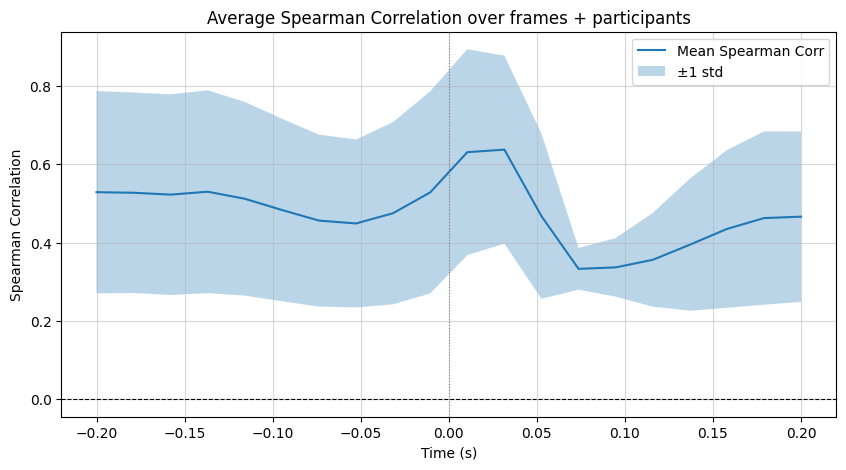

In [ ]:
sr = 50
pos_offset = 20 
neg_offset = 10
total_len = pos_offset + neg_offset
time_axis = np.linspace(-neg_offset / sr, pos_offset / sr, total_len)

def t2reli(t, start=start_time_s, sr=50):
    return int((t - start) * sr)

all_frames = []

for i in range(1, 10):  # subjects 1 through 9
    corr = corr_dict[i]  # (T, D)

    for s, e in sylber_seg:
        si = t2reli(s)
        if si > neg_offset and si + pos_offset <= len(corr):
            corr_frame = corr[si - neg_offset : si + pos_offset]  # (total_len, D)
            all_frames.append(corr_frame)

all_frames = np.stack(all_frames)
mean_corr = all_frames.mean(axis=0)
std_corr = all_frames.std(axis=0)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time_axis, mean_corr, label='Mean Spearman Corr')
plt.fill_between(time_axis, mean_corr - std_corr, mean_corr + std_corr, alpha=0.3, label='±1 std')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle=':', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Spearman Correlation")
plt.title("Average Spearman Correlation Aligned to Event Onsets")
plt.legend()

Let's try our main loss function, cosine similarity.

In [88]:
def componentwise_cosine(X, Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    assert X.shape == Y.shape, "Signals must have the same shape"
    
    # Normalize vectors along feature dimension
    X_norm = np.linalg.norm(X, axis=1)
    Y_norm = np.linalg.norm(Y, axis=1)
    
    # Avoid division by zero
    valid = (X_norm > 0) & (Y_norm > 0)
    
    sims = np.zeros(X.shape[0])
    sims[valid] = np.sum(X[valid] * Y[valid], axis=1) / (X_norm[valid] * Y_norm[valid])
    
    return sims

cos_dict = {}
for i in tqdm(range(1,10)):
    preds = sub_dict[i][0]
    gt = sub_dict[i][1]
    cos_dict[i] = componentwise_cosine(gt, preds)

100%|██████████| 9/9 [00:00<00:00, 20.06it/s]


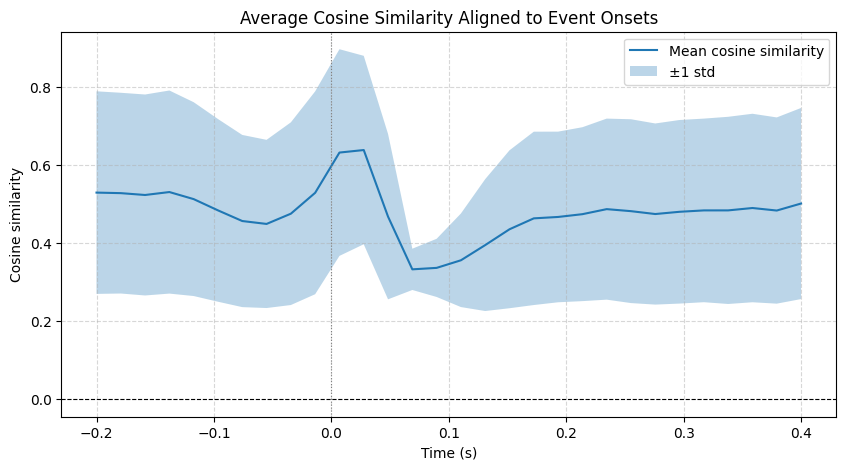

In [91]:
sr = 50
pos_offset = 20 
neg_offset = 10
total_len = pos_offset + neg_offset
time_axis = np.linspace(-neg_offset / sr, pos_offset / sr, total_len)

def t2reli(t, start=start_time_s, sr=50):
    return int((t - start) * sr)

all_frames = []

for i in range(1, 10):  # subjects 1 through 9
    cos = cos_dict[i]  # (T, D)

    for s, e in sylber_seg:
        si = t2reli(s)
        if si > neg_offset and si + pos_offset <= len(cos):
            cos_frame = corr[si - neg_offset : si + pos_offset]  # (total_len, D)
            all_frames.append(cos_frame)

all_frames = np.stack(all_frames)
mean_cos = all_frames.mean(axis=0)
std_cos = all_frames.std(axis=0)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time_axis, mean_cos, label='Mean cosine similarity')
plt.fill_between(time_axis, mean_cos - std_cos, mean_cos + std_cos, alpha=0.3, label='±1 std')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle=':', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Cosine similarity")
plt.title("Average Cosine Similarity Aligned to Event Onsets")
plt.legend()

# SYLLABLE CLUSTERING

In [114]:
import ruptures as rpt
from pydub import AudioSegment
from IPython.display import display, Audio

In [146]:
def ruptures_boundaries(sequence, model="l2", pen=2):
    algo = rpt.Pelt(model=model).fit(sequence)
    result = algo.predict(pen=pen)
    boundaries = [b-1 for b in result[:-1]]  # zero-based indices
    return boundaries

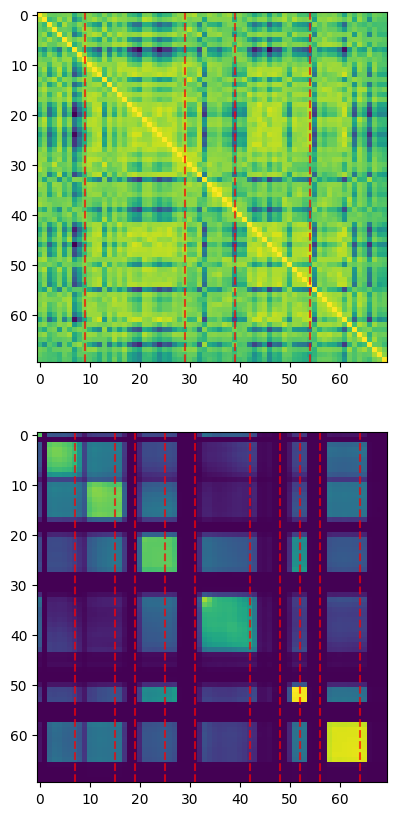

In [150]:
f, (a0, a1) = plt.subplots(2, 1,figsize=(5,10))
preds = sub_dict[1][0]
gt = sub_dict[1][1]
frame_si, frame_ei = 30, 100
#frame_si, frame_ei = t2reli(1620.4), t2reli(1621.4)
preds_frame = preds[frame_si:frame_ei]
gt_frame = gt[frame_si:frame_ei]
bdr = ruptures_boundaries(preds_frame)
a0.imshow(preds_frame@preds_frame.T)
a1.imshow(gt_frame@gt_frame.T)
for f in bdr:
    a0.axvline(f, color='red',ls='--',alpha=0.7,label='onset')
for s, e in sylber_seg:
    si, ei = t2reli(s), t2reli(e)
    if frame_si < si < frame_ei and frame_si < ei < frame_ei:
        a1.axvline(si - frame_si, color='red', ls='--', alpha=0.7, label='onset')
        a1.axvline(ei - frame_si, color='red', ls='--', alpha=0.7, label='onset')

In [151]:
audio = AudioSegment.from_file("pickled_podcast/samples/podcast_resampled.wav")

In [152]:
def relf2t(frame_idx, start=start_time_s, sr=50):
    return frame_idx / sr + start

# Extract and play the full segment corresponding to frame_si:frame_ei
start_ms = int(relf2t(frame_si) * 1000)  # pydub uses milliseconds
end_ms = int(relf2t(frame_ei) * 1000)
full_segment = audio[start_ms:end_ms]

print("Full segment player:")
display(Audio(full_segment.export(format="wav").read(), rate=audio.frame_rate))

# Now for each detected boundary segment in bdr
print("Segmented players:")

# Add 0 and length of segment to boundaries to define segment edges
segment_boundaries = [0] + bdr + [frame_ei - frame_si]  # indices relative to preds_frame

for i in range(len(segment_boundaries) - 1):
    seg_start_frame = segment_boundaries[i] + frame_si
    seg_end_frame = segment_boundaries[i+1] + frame_si
    seg_start_ms = int(relf2t(seg_start_frame) * 1000)
    seg_end_ms = int(relf2t(seg_end_frame) * 1000)
    segment = audio[seg_start_ms:seg_end_ms]
    
    print(f"Segment {i+1}: frames {seg_start_frame} to {seg_end_frame}")
    display(Audio(segment.export(format="wav").read(), rate=audio.frame_rate))

Full segment player:


Segmented players:
Segment 1: frames 30 to 39


Segment 2: frames 39 to 59


Segment 3: frames 59 to 69


Segment 4: frames 69 to 84


Segment 5: frames 84 to 100
